In [49]:
import torch
torch.set_default_tensor_type(torch.FloatTensor)
from torch.autograd import Variable
from torch.nn import functional as F
from torchmetrics import Accuracy, Recall, Precision, Specificity, ConfusionMatrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
from collections import Counter
import random
import math
import torch.optim as optim
from tabulate import tabulate
from ray import tune

from fractions import Fraction

In [50]:
# Create Tensors to hold input and outputs.
beta_1=np.append(np.array([4,4,-8,-4,6,8,-4,4,-6,4]),np.zeros(90))
beta_2=np.append(np.array([-2,2,4,-2,3,-4,2,-2,-3,2]),np.zeros(90))
beta_3=np.append(np.array([-3,-3,6,-3,-4.5,-6,3,-3,4.5,3]),np.zeros(90))

beta_1=beta_1.reshape(-1,1)
beta_2=beta_2.reshape(-1,1)
beta_3=beta_3.reshape(-1,1)

n1=200
n2=200
n3=200
p=100
corval=0
prior=2

def sigmoid(X):
    return .5 * (1 + np.tanh(.5 * X))

def generate_data(corval,beta,n,p):
    mean=np.zeros(p)
    sigma=np.array([[corval**abs(i-j) for i in range(p)] for j in range(p)])
    x=torch.tensor(np.random.multivariate_normal(mean=mean,cov=sigma,size=n))
    Pi_test= sigmoid(x@beta)
    y=np.random.binomial(1,Pi_test.ravel(),n)
    x=x.to(torch.float32)
    #y=torch.tensor(y,dtype=torch.double)
    y=torch.tensor(y,dtype=torch.float)
    #y=y.to(torch.float32)
    return x,y


In [51]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(1)

# generation of training and test data
x1,y1=generate_data(corval,beta_1,n1,p)
x2,y2=generate_data(corval,beta_2,n2,p)
x3,y3=generate_data(corval,beta_3,n3,p)

train_x1, test_x1, train_y1, test_y1= train_test_split(x1,y1, test_size=0.2, random_state=1)
train_x2, test_x2, train_y2, test_y2= train_test_split(x2,y2, test_size=0.2, random_state=1)
train_x3, test_x3, train_y3, test_y3= train_test_split(x3,y3, test_size=0.2, random_state=1)

#test_x1,test_y1=generaet_data(corval,beta_1,n_test,p)
#test_x2,test_y2=generaet_data(corval,beta_2,n_test,p)
#test_x3,test_y3=generaet_data(corval,beta_3,n_test,p)


tensor(0.2181, dtype=torch.float64)

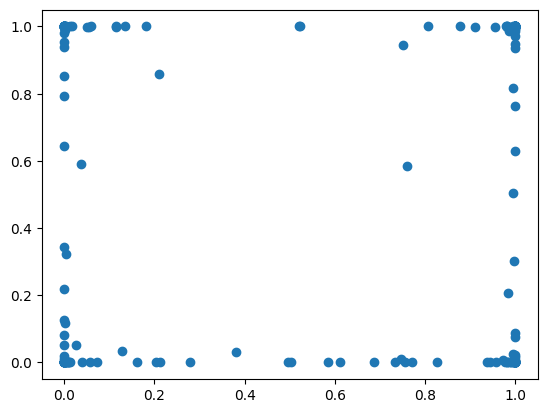

In [52]:
plt.scatter(sigmoid(x3@beta_3).squeeze(),sigmoid(x1@beta_1).squeeze())
sigmoid(x3@beta_3).squeeze().cov()

In [53]:
    # switch training set
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3

    # switching testing set
    test_inputs_1, test_targets_1 = test_x1,test_y1
    test_inputs_2, test_targets_2 = test_x2,test_y2
    test_inputs_3, test_targets_3 = test_x3,test_y3

In [54]:
################## first step##################
prior=2
# choose lambda1,lambda2 by ray tune
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out
    
def train_model(config):
    split_num=10
    kf = KFold(n_splits=split_num)



    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
        lambda1,lambda2 = config["lambda1"], config["lambda2"]
        model_1=MLP(seed=1)
        model_2=MLP(seed=1)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=0.8
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params,
                                           model_2_all_linear2_params,model_2_all_linear3_params,
                                           model_3_all_linear2_params,model_3_all_linear3_params),0)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear23_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3= model_3(train_x3[idx_test])
        
        test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
        test_BCE_loss_2 = loss_fn(test_out_2, targets_2[idx_test].reshape(-1,1))
        test_BCE_loss_3 = loss_fn(test_out_3, targets_3[idx_test].reshape(-1,1))
        
        test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
        sum_test_BCE_loss+=test_BCE_loss.item()

    #print("loss: ",)
    tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)
     
        
if __name__ == '__main__':
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
    config={
        "lambda1": tune.choice([0.01,0.02,0.03,0.04,0.05]),
        "lambda2": tune.choice([0.001,0.002])
    }


    result = tune.run(
        train_model,  
        config=config,
        num_samples=50)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


Trial name,status,loc,lambda1,lambda2,iter,total time (s),my_test_BCE_loss
train_model_7cc2d_00000,TERMINATED,10.224.0.12:26291,0.04,0.002,1,24.4996,1.17197
train_model_7cc2d_00001,TERMINATED,10.224.0.12:26779,0.05,0.002,1,24.5725,1.09921
train_model_7cc2d_00002,TERMINATED,10.224.0.12:26781,0.01,0.002,1,23.8518,1.54642
train_model_7cc2d_00003,TERMINATED,10.224.0.12:26783,0.01,0.002,1,26.7591,1.54642
train_model_7cc2d_00004,TERMINATED,10.224.0.12:26785,0.04,0.002,1,25.0279,1.17197
train_model_7cc2d_00005,TERMINATED,10.224.0.12:26789,0.03,0.001,1,24.2857,1.46181
train_model_7cc2d_00006,TERMINATED,10.224.0.12:26790,0.02,0.002,1,27.3265,1.4726
train_model_7cc2d_00007,TERMINATED,10.224.0.12:26792,0.01,0.001,1,25.718,1.66337
train_model_7cc2d_00008,TERMINATED,10.224.0.12:26793,0.04,0.001,1,23.8408,1.19658
train_model_7cc2d_00009,TERMINATED,10.224.0.12:26797,0.03,0.002,1,26.5177,1.36935


Result for train_model_7cc2d_00000:
  date: 2022-10-12_19-18-08
  done: false
  experiment_id: 7583c1a4e91a4ccf834a2469929d3259
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1719655573368073
  node_ip: 10.224.0.12
  pid: 26291
  time_since_restore: 24.49964451789856
  time_this_iter_s: 24.49964451789856
  time_total_s: 24.49964451789856
  timestamp: 1665573488
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7cc2d_00000
  warmup_time: 0.003050088882446289
  
Result for train_model_7cc2d_00000:
  date: 2022-10-12_19-18-08
  done: true
  experiment_id: 7583c1a4e91a4ccf834a2469929d3259
  experiment_tag: 0_lambda1=0.0400,lambda2=0.0020
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1719655573368073
  node_ip: 10.224.0.12
  pid: 26291
  time_since_restore: 24.49964451789856
  time_this_iter_s: 24.49964451789856
  time_total_s: 24.49964451789856
  timestamp: 1665573488
  timesteps_since_restore: 0
  tr

Result for train_model_7cc2d_00031:
  date: 2022-10-12_19-18-12
  done: false
  experiment_id: 2e87145ef3ac413ab0c8b58e45e1ffb2
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.4618147671222688
  node_ip: 10.224.0.12
  pid: 26842
  time_since_restore: 24.120954990386963
  time_this_iter_s: 24.120954990386963
  time_total_s: 24.120954990386963
  timestamp: 1665573492
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7cc2d_00031
  warmup_time: 0.004814863204956055
  
Result for train_model_7cc2d_00031:
  date: 2022-10-12_19-18-12
  done: true
  experiment_id: 2e87145ef3ac413ab0c8b58e45e1ffb2
  experiment_tag: 31_lambda1=0.0300,lambda2=0.0010
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.4618147671222688
  node_ip: 10.224.0.12
  pid: 26842
  time_since_restore: 24.120954990386963
  time_this_iter_s: 24.120954990386963
  time_total_s: 24.120954990386963
  timestamp: 1665573492
  timesteps_since_restore:

Result for train_model_7cc2d_00027:
  date: 2022-10-12_19-18-13
  done: false
  experiment_id: cefb2abdb98b4116bbf60964305ce590
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.6633732318878174
  node_ip: 10.224.0.12
  pid: 26834
  time_since_restore: 25.305522680282593
  time_this_iter_s: 25.305522680282593
  time_total_s: 25.305522680282593
  timestamp: 1665573493
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7cc2d_00027
  warmup_time: 0.005522489547729492
  
Result for train_model_7cc2d_00027:
  date: 2022-10-12_19-18-13
  done: true
  experiment_id: cefb2abdb98b4116bbf60964305ce590
  experiment_tag: 27_lambda1=0.0100,lambda2=0.0010
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.6633732318878174
  node_ip: 10.224.0.12
  pid: 26834
  time_since_restore: 25.305522680282593
  time_this_iter_s: 25.305522680282593
  time_total_s: 25.305522680282593
  timestamp: 1665573493
  timesteps_since_restore:

Result for train_model_7cc2d_00013:
  date: 2022-10-12_19-18-15
  done: false
  experiment_id: af6dd95c865e452185144332152c351b
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1965799510478974
  node_ip: 10.224.0.12
  pid: 26805
  time_since_restore: 27.37861967086792
  time_this_iter_s: 27.37861967086792
  time_total_s: 27.37861967086792
  timestamp: 1665573495
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7cc2d_00013
  warmup_time: 0.0059528350830078125
  
Result for train_model_7cc2d_00013:
  date: 2022-10-12_19-18-15
  done: true
  experiment_id: af6dd95c865e452185144332152c351b
  experiment_tag: 13_lambda1=0.0400,lambda2=0.0010
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1965799510478974
  node_ip: 10.224.0.12
  pid: 26805
  time_since_restore: 27.37861967086792
  time_this_iter_s: 27.37861967086792
  time_total_s: 27.37861967086792
  timestamp: 1665573495
  timesteps_since_restore: 0
  

Result for train_model_7cc2d_00036:
  date: 2022-10-12_19-18-29
  done: false
  experiment_id: e0c28ca82358442381787577bcf858b9
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5464203357696533
  node_ip: 10.224.0.12
  pid: 26803
  time_since_restore: 16.879237174987793
  time_this_iter_s: 16.879237174987793
  time_total_s: 16.879237174987793
  timestamp: 1665573509
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7cc2d_00036
  warmup_time: 0.005719661712646484
  
Result for train_model_7cc2d_00036:
  date: 2022-10-12_19-18-29
  done: true
  experiment_id: e0c28ca82358442381787577bcf858b9
  experiment_tag: 36_lambda1=0.0100,lambda2=0.0020
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5464203357696533
  node_ip: 10.224.0.12
  pid: 26803
  time_since_restore: 16.879237174987793
  time_this_iter_s: 16.879237174987793
  time_total_s: 16.879237174987793
  timestamp: 1665573509
  timesteps_since_restore:

Result for train_model_7cc2d_00035:
  date: 2022-10-12_19-18-31
  done: true
  experiment_id: 8118a34b89e44011b9857f3286926948
  experiment_tag: 35_lambda1=0.0100,lambda2=0.0010
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.6633732318878174
  node_ip: 10.224.0.12
  pid: 26793
  time_since_restore: 19.738370895385742
  time_this_iter_s: 19.738370895385742
  time_total_s: 19.738370895385742
  timestamp: 1665573511
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7cc2d_00035
  warmup_time: 0.00790095329284668
  
Result for train_model_7cc2d_00045:
  date: 2022-10-12_19-18-32
  done: false
  experiment_id: 8f8852989b28499ab1ac88cfb755215e
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.6633732318878174
  node_ip: 10.224.0.12
  pid: 26809
  time_since_restore: 19.007797479629517
  time_this_iter_s: 19.007797479629517
  time_total_s: 19.007797479629517
  timestamp: 1665573512
  timesteps_since_restore: 

2022-10-12 19:18:32,741	INFO tune.py:758 -- Total run time: 51.16 seconds (50.81 seconds for the tuning loop).


======================== Result =========================
             my_test_BCE_loss  time_this_iter_s  done timesteps_total  \
trial_id                                                                
7cc2d_00000          1.171966         24.499645  True            None   
7cc2d_00001          1.099210         24.572477  True            None   
7cc2d_00002          1.546420         23.851822  True            None   
7cc2d_00003          1.546420         26.759057  True            None   
7cc2d_00004          1.171966         25.027930  True            None   
7cc2d_00005          1.461815         24.285656  True            None   
7cc2d_00006          1.472600         27.326526  True            None   
7cc2d_00007          1.663373         25.717967  True            None   
7cc2d_00008          1.196580         23.840768  True            None   
7cc2d_00009          1.369354         26.517660  True            None   
7cc2d_00010          1.196580         24.099875  True            N

In [55]:
best_trial = result.get_best_trial("my_test_BCE_loss", "min", "last")
print("Best trial final validation loss: {}".format(best_trial.last_result["my_test_BCE_loss"]))
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
final_lambda

Best trial final validation loss: 1.0992100238800049


{'lambda1': 0.05, 'lambda2': 0.002}

In [56]:
################## second step##################

#0.4,0.4
# set hyperparamters
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
lambda1,lambda2=final_lambda["lambda1"],final_lambda["lambda2"]
learning_rate=0.8
max_iteration=1000

# switch training set
inputs_1,targets_1 = train_x1,train_y1
inputs_2,targets_2 = train_x2,train_y2
inputs_3,targets_3 = train_x3,train_y3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out


model_1=MLP(seed=2)
model_2=MLP(seed=1)
model_3=MLP(seed=2)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])

    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])

    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, 
                                     model_2_all_linear2_params,model_2_all_linear3_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params),0)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear23_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(0.1966, grad_fn=<AddBackward0>)

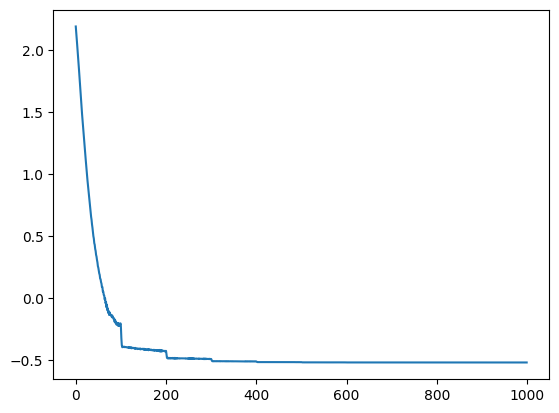

In [57]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

In [58]:
################## Y_prior##################

y_prior_1= (model_1(train_x1)[0]).detach().squeeze()

y_prior_2= (model_2(train_x2)[0]).detach().squeeze()

y_prior_3= (model_3(train_x2)[0]).detach().squeeze()
BCE_loss_1 = loss_fn(y_prior_1,train_y1)
BCE_loss_2 = loss_fn(y_prior_2, train_y2)
BCE_loss_3 = loss_fn(y_prior_3, train_y3)
BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
BCE_loss

BCE_loss_1
BCE_loss_2
BCE_loss_3

tensor(1.9722)

tensor(0.0980)

tensor(0.0112)

tensor(1.8631)

In [59]:
y_p_1= (model_1(train_x1)[0]>0.5).clone().int()
t_p_1= train_y1.reshape(-1,1).int()

y_p_2= (model_2(train_x2)[0]>0.5).clone().int()
t_p_2= train_y2.reshape(-1,1).int()

y_p_3= (model_3(train_x3)[0]>0.5).clone().int()
t_p_3= train_y3.reshape(-1,1).int()

confusion_matrix(t_p_1,y_p_1)
confusion_matrix(t_p_2,y_p_2)
confusion_matrix(t_p_3,y_p_3)

array([[89,  1],
       [ 1, 69]])

array([[88,  0],
       [ 0, 72]])

array([[68,  1],
       [ 1, 90]])

In [60]:
################## third step##################

#no prior
prior=0
# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3



# choose lambda1,lambda2 by ray tune
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)
    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    
def train_model(config):
    split_num=10
    kf = KFold(n_splits=split_num)
    
    
    lambda1,lambda2,eta = config["lambda1"], config["lambda2"],config["eta"]
    inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
    targets_1=(1-eta)*train_y1+eta*y_prior_1
    targets_2=(1-eta)*train_y2+eta*y_prior_2
    targets_3=(1-eta)*train_y3+eta*y_prior_3
    
    
    
    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
       
        
        model_1=MLP(seed=1)
        model_2=MLP(seed=1)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=0.8
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
            model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
            model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
            model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                             model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                             model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear234_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1,test_layer3_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2,test_layer3_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3,test_layer3_out_3= model_3(train_x3[idx_test])
        
#         test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
#         test_BCE_loss_2 = loss_fn(test_out_2, targets_1[idx_test].reshape(-1,1))
#         test_BCE_loss_3 = loss_fn(test_out_3, targets_1[idx_test].reshape(-1,1))

        test_BCE_loss_1 = loss_fn(test_out_1, train_y1[idx_test].reshape(-1,1))
        test_BCE_loss_2 = loss_fn(test_out_2, train_y2[idx_test].reshape(-1,1))
        test_BCE_loss_3 = loss_fn(test_out_3, train_y3[idx_test].reshape(-1,1))
        
        test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
        sum_test_BCE_loss+=test_BCE_loss.item()

    #print("loss: ",)
    tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)
     
        
if __name__ == '__main__':
#     inputs_1,targets_1 = train_x1,train_y1
#     inputs_2,targets_2 = train_x2,train_y2
#     inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
    config={
        "lambda1": tune.choice([0.04,0.05]),
        "lambda2": tune.choice([0.001,0.002,0.003]),
        "eta": tune.choice([0.06,0.09,0.1,0.12,0.15,0.17,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95])
    }


    result = tune.run(
        train_model,  
        config=config,
        num_samples=100)
    
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


Trial name,status,loc,eta,lambda1,lambda2,iter,total time (s),my_test_BCE_loss
train_model_a7fe4_00000,TERMINATED,10.224.0.12:28325,0.25,0.05,0.003,1,29.6754,1.17231
train_model_a7fe4_00001,TERMINATED,10.224.0.12:28761,0.55,0.05,0.001,1,31.1692,1.32827
train_model_a7fe4_00002,TERMINATED,10.224.0.12:28763,0.75,0.04,0.001,1,28.9692,1.44837
train_model_a7fe4_00003,TERMINATED,10.224.0.12:28765,0.15,0.04,0.001,1,33.1278,1.27361
train_model_a7fe4_00004,TERMINATED,10.224.0.12:28767,0.45,0.04,0.003,1,31.5379,1.27498
train_model_a7fe4_00005,TERMINATED,10.224.0.12:28769,0.75,0.04,0.003,1,31.4801,1.39058
train_model_a7fe4_00006,TERMINATED,10.224.0.12:28771,0.06,0.04,0.003,1,31.5725,1.11959
train_model_a7fe4_00007,TERMINATED,10.224.0.12:28773,0.45,0.05,0.001,1,30.1869,1.26409
train_model_a7fe4_00008,TERMINATED,10.224.0.12:28775,0.09,0.04,0.002,1,30.2575,1.18168
train_model_a7fe4_00009,TERMINATED,10.224.0.12:28777,0.45,0.05,0.002,1,31.4439,1.25543


Result for train_model_a7fe4_00000:
  date: 2022-10-12_19-19-26
  done: false
  experiment_id: 9127fb6ec5cf4b41baf00a5e2dd41216
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1723088264465331
  node_ip: 10.224.0.12
  pid: 28325
  time_since_restore: 29.675352096557617
  time_this_iter_s: 29.675352096557617
  time_total_s: 29.675352096557617
  timestamp: 1665573566
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a7fe4_00000
  warmup_time: 0.0036563873291015625
  
Result for train_model_a7fe4_00000:
  date: 2022-10-12_19-19-26
  done: true
  experiment_id: 9127fb6ec5cf4b41baf00a5e2dd41216
  experiment_tag: 0_eta=0.2500,lambda1=0.0500,lambda2=0.0030
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1723088264465331
  node_ip: 10.224.0.12
  pid: 28325
  time_since_restore: 29.675352096557617
  time_this_iter_s: 29.675352096557617
  time_total_s: 29.675352096557617
  timestamp: 1665573566
  timesteps_sin

Result for train_model_a7fe4_00010:
  date: 2022-10-12_19-19-30
  done: false
  experiment_id: 1b37e14ec2d24102b841a8e087c3b7ed
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3748832106590272
  node_ip: 10.224.0.12
  pid: 28779
  time_since_restore: 29.893685579299927
  time_this_iter_s: 29.893685579299927
  time_total_s: 29.893685579299927
  timestamp: 1665573570
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a7fe4_00010
  warmup_time: 0.00488591194152832
  
Result for train_model_a7fe4_00010:
  date: 2022-10-12_19-19-30
  done: true
  experiment_id: 1b37e14ec2d24102b841a8e087c3b7ed
  experiment_tag: 10_eta=0.6500,lambda1=0.0400,lambda2=0.0020
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3748832106590272
  node_ip: 10.224.0.12
  pid: 28779
  time_since_restore: 29.893685579299927
  time_this_iter_s: 29.893685579299927
  time_total_s: 29.893685579299927
  timestamp: 1665573570
  timesteps_sinc

Result for train_model_a7fe4_00027:
  date: 2022-10-12_19-19-31
  done: true
  experiment_id: ce02398e5704442abee67aa1afb04527
  experiment_tag: 27_eta=0.9500,lambda1=0.0400,lambda2=0.0010
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.7080623865127564
  node_ip: 10.224.0.12
  pid: 28813
  time_since_restore: 30.805253505706787
  time_this_iter_s: 30.805253505706787
  time_total_s: 30.805253505706787
  timestamp: 1665573571
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a7fe4_00027
  warmup_time: 0.00444340705871582
  
Result for train_model_a7fe4_00009:
  date: 2022-10-12_19-19-32
  done: false
  experiment_id: 0b392e8efc764c9b92bb3960d4413ef5
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2554290294647217
  node_ip: 10.224.0.12
  pid: 28777
  time_since_restore: 31.4438955783844
  time_this_iter_s: 31.4438955783844
  time_total_s: 31.4438955783844
  timestamp: 1665573572
  timesteps_since_rest

Result for train_model_a7fe4_00003:
  date: 2022-10-12_19-19-33
  done: false
  experiment_id: b4e7b146a9964ce08aee471824688286
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2736077070236207
  node_ip: 10.224.0.12
  pid: 28765
  time_since_restore: 33.12781095504761
  time_this_iter_s: 33.12781095504761
  time_total_s: 33.12781095504761
  timestamp: 1665573573
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a7fe4_00003
  warmup_time: 0.006337881088256836
  
Result for train_model_a7fe4_00003:
  date: 2022-10-12_19-19-33
  done: true
  experiment_id: b4e7b146a9964ce08aee471824688286
  experiment_tag: 3_eta=0.1500,lambda1=0.0400,lambda2=0.0010
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2736077070236207
  node_ip: 10.224.0.12
  pid: 28765
  time_since_restore: 33.12781095504761
  time_this_iter_s: 33.12781095504761
  time_total_s: 33.12781095504761
  timestamp: 1665573573
  timesteps_since_rest

Result for train_model_a7fe4_00040:
  date: 2022-10-12_19-19-59
  done: false
  experiment_id: dece04437d214b0e97e525111b312fb9
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2917340517044067
  node_ip: 10.224.0.12
  pid: 28793
  time_since_restore: 29.67488980293274
  time_this_iter_s: 29.67488980293274
  time_total_s: 29.67488980293274
  timestamp: 1665573599
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a7fe4_00040
  warmup_time: 0.006544351577758789
  
Result for train_model_a7fe4_00040:
  date: 2022-10-12_19-19-59
  done: true
  experiment_id: dece04437d214b0e97e525111b312fb9
  experiment_tag: 40_eta=0.0600,lambda1=0.0400,lambda2=0.0010
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2917340517044067
  node_ip: 10.224.0.12
  pid: 28793
  time_since_restore: 29.67488980293274
  time_this_iter_s: 29.67488980293274
  time_total_s: 29.67488980293274
  timestamp: 1665573599
  timesteps_since_res

Result for train_model_a7fe4_00041:
  date: 2022-10-12_19-20-00
  done: false
  experiment_id: 1b37e14ec2d24102b841a8e087c3b7ed
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.0777220189571382
  node_ip: 10.224.0.12
  pid: 28779
  time_since_restore: 30.35518169403076
  time_this_iter_s: 30.35518169403076
  time_total_s: 30.35518169403076
  timestamp: 1665573600
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a7fe4_00041
  warmup_time: 0.00488591194152832
  
Result for train_model_a7fe4_00041:
  date: 2022-10-12_19-20-00
  done: true
  experiment_id: 1b37e14ec2d24102b841a8e087c3b7ed
  experiment_tag: 41_eta=0.1200,lambda1=0.0500,lambda2=0.0030
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.0777220189571382
  node_ip: 10.224.0.12
  pid: 28779
  time_since_restore: 30.35518169403076
  time_this_iter_s: 30.35518169403076
  time_total_s: 30.35518169403076
  timestamp: 1665573600
  timesteps_since_rest

Result for train_model_a7fe4_00048:
  date: 2022-10-12_19-20-03
  done: false
  experiment_id: 05421c4594234c808203277733df60a1
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1723088264465331
  node_ip: 10.224.0.12
  pid: 28767
  time_since_restore: 31.191071271896362
  time_this_iter_s: 31.191071271896362
  time_total_s: 31.191071271896362
  timestamp: 1665573603
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a7fe4_00048
  warmup_time: 0.004793405532836914
  
Result for train_model_a7fe4_00048:
  date: 2022-10-12_19-20-03
  done: true
  experiment_id: 05421c4594234c808203277733df60a1
  experiment_tag: 48_eta=0.2500,lambda1=0.0500,lambda2=0.0030
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1723088264465331
  node_ip: 10.224.0.12
  pid: 28767
  time_since_restore: 31.191071271896362
  time_this_iter_s: 31.191071271896362
  time_total_s: 31.191071271896362
  timestamp: 1665573603
  timesteps_sin

Result for train_model_a7fe4_00057:
  date: 2022-10-12_19-20-05
  done: false
  experiment_id: b572f0783047439094b781840dda0441
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1614259243011475
  node_ip: 10.224.0.12
  pid: 28821
  time_since_restore: 32.05570125579834
  time_this_iter_s: 32.05570125579834
  time_total_s: 32.05570125579834
  timestamp: 1665573605
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a7fe4_00057
  warmup_time: 0.012705087661743164
  
Result for train_model_a7fe4_00057:
  date: 2022-10-12_19-20-05
  done: true
  experiment_id: b572f0783047439094b781840dda0441
  experiment_tag: 57_eta=0.0600,lambda1=0.0400,lambda2=0.0020
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1614259243011475
  node_ip: 10.224.0.12
  pid: 28821
  time_since_restore: 32.05570125579834
  time_this_iter_s: 32.05570125579834
  time_total_s: 32.05570125579834
  timestamp: 1665573605
  timesteps_since_res

Result for train_model_a7fe4_00072:
  date: 2022-10-12_19-20-29
  done: false
  experiment_id: 3e27105854bc49dcae5647830f27ac7f
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.4859971165657044
  node_ip: 10.224.0.12
  pid: 28785
  time_since_restore: 29.520797729492188
  time_this_iter_s: 29.520797729492188
  time_total_s: 29.520797729492188
  timestamp: 1665573629
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a7fe4_00072
  warmup_time: 0.00477290153503418
  
Result for train_model_a7fe4_00072:
  date: 2022-10-12_19-20-29
  done: true
  experiment_id: 3e27105854bc49dcae5647830f27ac7f
  experiment_tag: 72_eta=0.8500,lambda1=0.0500,lambda2=0.0020
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.4859971165657044
  node_ip: 10.224.0.12
  pid: 28785
  time_since_restore: 29.520797729492188
  time_this_iter_s: 29.520797729492188
  time_total_s: 29.520797729492188
  timestamp: 1665573629
  timesteps_sinc

Result for train_model_a7fe4_00076:
  date: 2022-10-12_19-20-31
  done: false
  experiment_id: 1b37e14ec2d24102b841a8e087c3b7ed
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1056973934173584
  node_ip: 10.224.0.12
  pid: 28779
  time_since_restore: 30.799185276031494
  time_this_iter_s: 30.799185276031494
  time_total_s: 30.799185276031494
  timestamp: 1665573631
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a7fe4_00076
  warmup_time: 0.00488591194152832
  
Result for train_model_a7fe4_00076:
  date: 2022-10-12_19-20-31
  done: true
  experiment_id: 1b37e14ec2d24102b841a8e087c3b7ed
  experiment_tag: 76_eta=0.1200,lambda1=0.0500,lambda2=0.0020
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1056973934173584
  node_ip: 10.224.0.12
  pid: 28779
  time_since_restore: 30.799185276031494
  time_this_iter_s: 30.799185276031494
  time_total_s: 30.799185276031494
  timestamp: 1665573631
  timesteps_sinc

Result for train_model_a7fe4_00084:
  date: 2022-10-12_19-20-33
  done: false
  experiment_id: 05421c4594234c808203277733df60a1
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3124772906303406
  node_ip: 10.224.0.12
  pid: 28767
  time_since_restore: 30.48053789138794
  time_this_iter_s: 30.48053789138794
  time_total_s: 30.48053789138794
  timestamp: 1665573633
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a7fe4_00084
  warmup_time: 0.004793405532836914
  
Result for train_model_a7fe4_00084:
  date: 2022-10-12_19-20-33
  done: true
  experiment_id: 05421c4594234c808203277733df60a1
  experiment_tag: 84_eta=0.5500,lambda1=0.0500,lambda2=0.0020
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3124772906303406
  node_ip: 10.224.0.12
  pid: 28767
  time_since_restore: 30.48053789138794
  time_this_iter_s: 30.48053789138794
  time_total_s: 30.48053789138794
  timestamp: 1665573633
  timesteps_since_res

Result for train_model_a7fe4_00089:
  date: 2022-10-12_19-20-35
  done: false
  experiment_id: b4e7b146a9964ce08aee471824688286
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1791906535625458
  node_ip: 10.224.0.12
  pid: 28765
  time_since_restore: 30.57509708404541
  time_this_iter_s: 30.57509708404541
  time_total_s: 30.57509708404541
  timestamp: 1665573635
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a7fe4_00089
  warmup_time: 0.006337881088256836
  
Result for train_model_a7fe4_00089:
  date: 2022-10-12_19-20-35
  done: true
  experiment_id: b4e7b146a9964ce08aee471824688286
  experiment_tag: 89_eta=0.2500,lambda1=0.0400,lambda2=0.0030
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1791906535625458
  node_ip: 10.224.0.12
  pid: 28765
  time_since_restore: 30.57509708404541
  time_this_iter_s: 30.57509708404541
  time_total_s: 30.57509708404541
  timestamp: 1665573635
  timesteps_since_res

2022-10-12 19:20:46,637	INFO tune.py:758 -- Total run time: 112.52 seconds (112.18 seconds for the tuning loop).


======================== Result =========================
             my_test_BCE_loss  time_this_iter_s  done timesteps_total  \
trial_id                                                                
a7fe4_00000          1.172309         29.675352  True            None   
a7fe4_00001          1.328269         31.169208  True            None   
a7fe4_00002          1.448370         28.969225  True            None   
a7fe4_00003          1.273608         33.127811  True            None   
a7fe4_00004          1.274980         31.537868  True            None   
...                       ...               ...   ...             ...   
a7fe4_00095          1.275543         29.223577  True            None   
a7fe4_00096          1.388704         18.449573  True            None   
a7fe4_00097          1.161426         17.571197  True            None   
a7fe4_00098          1.638236         17.583985  True            None   
a7fe4_00099          1.092258         17.093455  True            N

In [61]:
best_trial = result.get_best_trial("my_test_BCE_loss", "min", "last")
print("Best trial final validation loss: {}".format(best_trial.last_result["my_test_BCE_loss"]))
final_parameter=result.get_best_config('my_test_BCE_loss',mode='min')
final_parameter

Best trial final validation loss: 1.0350475192070008


{'lambda1': 0.05, 'lambda2': 0.003, 'eta': 0.06}

In [62]:
################## second step##################

#no prior
prior=0

#0.4,0.4
# set hyperparamters
final_parameter=result.get_best_config('my_test_BCE_loss',mode='min')
lambda1,lambda2,eta=final_parameter["lambda1"],final_parameter["lambda2"],final_parameter["eta"]
learning_rate=0.8
max_iteration=1000


inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
targets_1=(1-eta)*train_y1+eta*y_prior_1
targets_2=(1-eta)*train_y2+eta*y_prior_2
targets_3=(1-eta)*train_y3+eta*y_prior_3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    


model_1=MLP(seed=1)
model_2=MLP(seed=1)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
    model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                     model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear234_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(0.3141, grad_fn=<AddBackward0>)

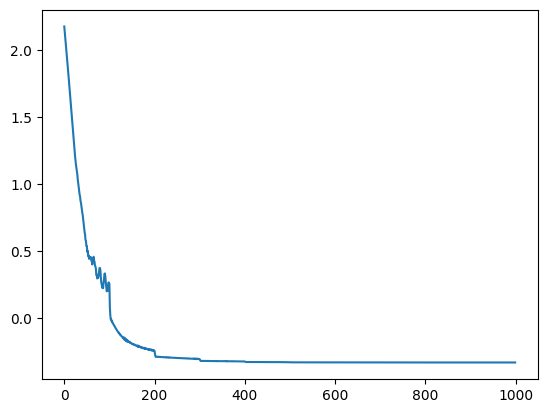

In [63]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

In [64]:
model_1_all_linear1_params.reshape(1,-1)
model_2_all_linear1_params.reshape(1,-1)
model_3_all_linear1_params.reshape(1,-1)

tensor([[-1.3050e-01, -1.7041e-01, -2.3228e-01, -1.3167e-01, -2.0557e-01,
         -2.2063e-01, -1.5098e-01, -1.4182e-01, -1.8652e-01, -1.4741e-01,
          1.8451e-06, -5.4655e-07, -9.0909e-07,  9.3627e-04,  4.9149e-07,
          4.1381e-07,  2.0213e-06, -2.4171e-06,  3.3381e-06, -4.0265e-06,
          5.2795e-07,  2.9371e-06, -4.9478e-07,  2.5302e-06,  1.6048e-06,
          1.7833e-07,  1.0631e-06, -2.1191e-06, -4.5176e-06,  6.9607e-07,
         -4.0052e-07,  1.7283e-06,  1.5329e-06, -2.7902e-07, -2.0576e-06,
          3.4627e-06,  2.6400e-06, -1.9644e-06, -1.5711e-07,  4.3098e-07,
         -4.7552e-07, -1.4488e-06, -3.2902e-06,  9.0476e-07,  4.1051e-07,
          3.0645e-06, -1.7549e-06, -7.0144e-07,  1.6124e-06, -5.1667e-07,
         -3.0302e-06,  2.8471e-06,  2.9694e-06,  2.1451e-06,  2.0164e-06,
          2.2544e-06,  1.5233e-06,  2.3683e-06, -1.9727e-07, -1.6563e-06,
          5.3076e-08,  2.4247e-06, -6.3481e-05,  9.9847e-07,  3.8025e-06,
          2.2517e-06,  1.1340e-06,  1.

tensor([[-1.3050e-01, -1.7041e-01, -2.3228e-01, -1.3167e-01, -2.0557e-01,
         -2.2063e-01, -1.5098e-01, -1.4182e-01, -1.8652e-01, -1.4741e-01,
          1.8451e-06, -5.4655e-07, -9.0909e-07,  9.3627e-04,  4.9149e-07,
          4.1381e-07,  2.0213e-06, -2.4171e-06,  3.3381e-06, -4.0265e-06,
          5.2795e-07,  2.9371e-06, -4.9478e-07,  2.5302e-06,  1.6048e-06,
          1.7833e-07,  1.0631e-06, -2.1191e-06, -4.5176e-06,  6.9607e-07,
         -4.0052e-07,  1.7283e-06,  1.5329e-06, -2.7902e-07, -2.0576e-06,
          3.4627e-06,  2.6400e-06, -1.9644e-06, -1.5711e-07,  4.3098e-07,
         -4.7552e-07, -1.4488e-06, -3.2902e-06,  9.0476e-07,  4.1051e-07,
          3.0645e-06, -1.7549e-06, -7.0144e-07,  1.6124e-06, -5.1667e-07,
         -3.0302e-06,  2.8471e-06,  2.9694e-06,  2.1451e-06,  2.0164e-06,
          2.2544e-06,  1.5233e-06,  2.3683e-06, -1.9727e-07, -1.6563e-06,
          5.3076e-08,  2.4247e-06, -6.3481e-05,  9.9847e-07,  3.8025e-06,
          2.2517e-06,  1.1340e-06,  1.

tensor([[-1.6321e-01, -2.0048e-01, -2.5764e-01, -1.8808e-01,  1.9619e-01,
         -2.8259e-01, -1.7291e-01, -1.7043e-01, -1.8935e-01, -1.9759e-01,
         -7.5159e-07,  2.3713e-08,  1.0727e-07,  3.7839e-02,  1.0878e-08,
          1.3397e-09, -9.4190e-07,  2.2249e-07, -3.6606e-07,  2.0319e-07,
         -4.3090e-09, -6.2034e-08, -2.4565e-07, -1.1952e-07,  1.3687e-06,
         -1.8936e-08, -3.3867e-07, -4.8014e-07,  1.2334e-06, -1.9388e-07,
          6.0357e-08,  9.4666e-08,  1.5200e-07,  2.7828e-08,  5.5137e-07,
         -7.9692e-07,  1.2081e-08,  4.6862e-08,  8.5214e-08,  1.5972e-07,
          3.1265e-07, -7.6072e-08, -1.1012e-08, -5.7714e-09,  8.7383e-08,
          9.5262e-08, -1.0056e-06,  1.7764e-08,  8.2808e-08, -3.9792e-08,
         -5.5072e-08,  7.6087e-08,  3.8283e-08,  2.5006e-07,  1.1386e-07,
          1.9473e-07,  1.5928e-06,  2.8953e-07,  3.9032e-08, -6.7861e-08,
          3.0564e-08, -6.9795e-08, -4.7969e-03,  2.5594e-07,  1.5017e-07,
         -1.3082e-07,  1.5903e-07,  3.

In [65]:

model_1(test_x1)[0].squeeze()
model_2(test_x2)[0].squeeze()
model_3(test_x3)[0].squeeze()


tensor([9.8404e-01, 9.8586e-01, 1.5542e-01, 6.4733e-01, 9.6352e-04, 9.8490e-01,
        9.3881e-01, 5.0473e-02, 9.8106e-01, 8.4287e-01, 8.9813e-06, 9.8093e-01,
        9.9007e-01, 1.2130e-02, 5.1361e-01, 9.6867e-01, 7.9293e-02, 9.2884e-01,
        1.1955e-02, 4.0854e-03, 2.8878e-03, 9.7584e-01, 9.6679e-01, 4.8594e-01,
        7.3923e-01, 2.3461e-01, 2.0588e-01, 1.8033e-02, 5.5080e-01, 3.2040e-01,
        1.6123e-01, 1.7819e-01, 8.8702e-04, 5.2278e-01, 1.4554e-01, 8.2744e-01,
        9.2861e-01, 9.5299e-01, 2.6350e-01, 5.3834e-04],
       grad_fn=<SqueezeBackward0>)

tensor([7.7984e-02, 9.9746e-01, 2.5272e-02, 9.1536e-01, 8.1287e-01, 9.9447e-01,
        9.8579e-01, 9.9229e-01, 7.7461e-03, 8.1696e-01, 5.9205e-01, 9.9230e-01,
        5.8843e-07, 9.9741e-01, 8.0322e-02, 3.9879e-03, 9.9764e-01, 9.8466e-01,
        2.6559e-02, 9.0104e-01, 1.6498e-01, 2.2299e-01, 2.0432e-03, 2.6986e-07,
        7.7012e-01, 1.2689e-03, 2.0353e-01, 6.0061e-03, 2.2327e-01, 7.9202e-01,
        8.7694e-01, 5.6316e-02, 3.8429e-06, 9.7285e-02, 9.1859e-01, 9.9908e-01,
        9.7399e-01, 2.5975e-03, 9.9312e-01, 7.7058e-01],
       grad_fn=<SqueezeBackward0>)

tensor([0.4978, 0.9698, 0.9639, 0.9629, 0.0205, 0.2297, 0.6709, 0.1956, 0.9642,
        0.9455, 0.9271, 0.0551, 0.9757, 0.4408, 0.9744, 0.0941, 0.9761, 0.9592,
        0.9213, 0.9740, 0.8015, 0.4672, 0.8940, 0.8976, 0.1021, 0.0148, 0.0110,
        0.9707, 0.5435, 0.9625, 0.7703, 0.0040, 0.9064, 0.9297, 0.0176, 0.0823,
        0.4319, 0.8328, 0.4963, 0.1203], grad_fn=<SqueezeBackward0>)

In [66]:
################## third step ##################
################## testing stage ##################

prediction_1= (model_1(test_x1)[0]>0.5).clone().int()
target_1= test_y1.reshape(-1,1).int()

prediction_2= (model_2(test_x2)[0]>0.5).clone().int()
target_2= test_y2.reshape(-1,1).int()

prediction_3= (model_3(test_x3)[0]>0.5).clone().int()
target_3= test_y3.reshape(-1,1).int()

prediction=np.append(prediction_1,prediction_2)
prediction=np.append(prediction,prediction_3)
prediction=prediction.tolist()

target=np.append(target_1,target_2)
target=np.append(target,target_3)
target=target.tolist()

final_matrix=confusion_matrix(target,prediction)
final_matrix
recall_score(target,prediction)#TPR
final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
accuracy_score(target,prediction)
precision_score(target,prediction)
f1_score(target,prediction)

array([[45,  6],
       [11, 58]])

0.8405797101449275

0.8823529411764706

0.8583333333333333

0.90625

0.8721804511278196

In [68]:
final_matrix_1=confusion_matrix(target_1,prediction_1)
final_matrix_1
recall_score(target_1,prediction_1)#TPR
final_matrix_1[0,0]/(sum(final_matrix_1[0,:]))#TNR

final_matrix_2=confusion_matrix(target_2,prediction_2)
final_matrix_2
recall_score(target_2,prediction_2)#TPR
final_matrix_2[0,0]/(sum(final_matrix_2[0,:]))#TNR

final_matrix_3=confusion_matrix(target_3,prediction_3)
final_matrix_3
recall_score(target_3,prediction_3)#TPR
final_matrix_3[0,0]/(sum(final_matrix_3[0,:]))#TNR

array([[18,  0],
       [ 2, 20]])

0.9090909090909091

1.0

array([[11,  4],
       [ 8, 17]])

0.68

0.7333333333333333

array([[16,  2],
       [ 1, 21]])

0.9545454545454546

0.8888888888888888

In [69]:
# variable selection evaluation

def cubic_root(x):
    return math.copysign(math.pow(abs(x), 1.0/3.0), x)

model_1_weight=model_1_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_2_weight=model_1_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_3_weight=model_1_all_linear1_params.detach().numpy().copy().reshape(1,-1)

model_1_weight
model_2_weight
model_3_weight

array([[-1.3049619e-01, -1.7040944e-01, -2.3227985e-01, -1.3167413e-01,
        -2.0557308e-01, -2.2063483e-01, -1.5097719e-01, -1.4181760e-01,
        -1.8651518e-01, -1.4741108e-01,  1.8451212e-06, -5.4655254e-07,
        -9.0908947e-07,  9.3627174e-04,  4.9148503e-07,  4.1381188e-07,
         2.0213304e-06, -2.4171316e-06,  3.3380963e-06, -4.0265281e-06,
         5.2795127e-07,  2.9371367e-06, -4.9478018e-07,  2.5301547e-06,
         1.6047965e-06,  1.7832922e-07,  1.0631173e-06, -2.1191195e-06,
        -4.5176266e-06,  6.9606608e-07, -4.0051569e-07,  1.7282904e-06,
         1.5328669e-06, -2.7902436e-07, -2.0576481e-06,  3.4626862e-06,
         2.6400412e-06, -1.9643701e-06, -1.5710883e-07,  4.3098001e-07,
        -4.7552021e-07, -1.4488255e-06, -3.2902101e-06,  9.0475925e-07,
         4.1050529e-07,  3.0644874e-06, -1.7549147e-06, -7.0144341e-07,
         1.6123748e-06, -5.1666842e-07, -3.0301542e-06,  2.8471059e-06,
         2.9694206e-06,  2.1451422e-06,  2.0164073e-06,  2.25436

array([[-1.3049619e-01, -1.7040944e-01, -2.3227985e-01, -1.3167413e-01,
        -2.0557308e-01, -2.2063483e-01, -1.5097719e-01, -1.4181760e-01,
        -1.8651518e-01, -1.4741108e-01,  1.8451212e-06, -5.4655254e-07,
        -9.0908947e-07,  9.3627174e-04,  4.9148503e-07,  4.1381188e-07,
         2.0213304e-06, -2.4171316e-06,  3.3380963e-06, -4.0265281e-06,
         5.2795127e-07,  2.9371367e-06, -4.9478018e-07,  2.5301547e-06,
         1.6047965e-06,  1.7832922e-07,  1.0631173e-06, -2.1191195e-06,
        -4.5176266e-06,  6.9606608e-07, -4.0051569e-07,  1.7282904e-06,
         1.5328669e-06, -2.7902436e-07, -2.0576481e-06,  3.4626862e-06,
         2.6400412e-06, -1.9643701e-06, -1.5710883e-07,  4.3098001e-07,
        -4.7552021e-07, -1.4488255e-06, -3.2902101e-06,  9.0475925e-07,
         4.1050529e-07,  3.0644874e-06, -1.7549147e-06, -7.0144341e-07,
         1.6123748e-06, -5.1666842e-07, -3.0301542e-06,  2.8471059e-06,
         2.9694206e-06,  2.1451422e-06,  2.0164073e-06,  2.25436

array([[-1.3049619e-01, -1.7040944e-01, -2.3227985e-01, -1.3167413e-01,
        -2.0557308e-01, -2.2063483e-01, -1.5097719e-01, -1.4181760e-01,
        -1.8651518e-01, -1.4741108e-01,  1.8451212e-06, -5.4655254e-07,
        -9.0908947e-07,  9.3627174e-04,  4.9148503e-07,  4.1381188e-07,
         2.0213304e-06, -2.4171316e-06,  3.3380963e-06, -4.0265281e-06,
         5.2795127e-07,  2.9371367e-06, -4.9478018e-07,  2.5301547e-06,
         1.6047965e-06,  1.7832922e-07,  1.0631173e-06, -2.1191195e-06,
        -4.5176266e-06,  6.9606608e-07, -4.0051569e-07,  1.7282904e-06,
         1.5328669e-06, -2.7902436e-07, -2.0576481e-06,  3.4626862e-06,
         2.6400412e-06, -1.9643701e-06, -1.5710883e-07,  4.3098001e-07,
        -4.7552021e-07, -1.4488255e-06, -3.2902101e-06,  9.0475925e-07,
         4.1050529e-07,  3.0644874e-06, -1.7549147e-06, -7.0144341e-07,
         1.6123748e-06, -5.1666842e-07, -3.0301542e-06,  2.8471059e-06,
         2.9694206e-06,  2.1451422e-06,  2.0164073e-06,  2.25436

In [70]:
threshold=0.15
mcl_w=np.zeros(p)

for i in range(p):
    mcl_w[i]=cubic_root(model_1_weight[0,i]*model_2_weight[0,i]*model_3_weight[0,i])

max_mcl_w=max(abs(mcl_w))
for i in range(p):
    if (abs(mcl_w[i]))<=threshold*max_mcl_w:
        model_1_weight[0,i]=0
        model_2_weight[0,i]=0
        model_3_weight[0,i]=0
    else:
        model_1_weight[0,i]=model_1_weight[0,i]
        model_2_weight[0,i]=model_2_weight[0,i]
        model_3_weight[0,i]=model_3_weight[0,i]
index=np.nonzero(model_1_weight)[1]
model_1_weight
final_index=index+1
final_index
len(index)

array([[-0.13049619, -0.17040944, -0.23227985, -0.13167413, -0.20557308,
        -0.22063483, -0.1509772 , -0.1418176 , -0.18651518, -0.14741108,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 71])

11